In [12]:
# !cp /mnt/bulky2/mgasanov/DSSAT/SoilGridsDssat.ipynb .

In [1]:
# !pip -q install zarr
# !pip -q install xarray[complete]
# !pip -q install rioxarray
# !pip -q install geopandas
# !pip -q install DSSATTools
!pip3 -q install aiohttp
!pip3 -q install gdown
!pip3 -q install salib

In [1]:
from DSSATTools import (
    Crop,
    SoilProfile,
    Weather,
    Management,
    available_cultivars,
)

from DSSATTools import DSSAT
import pandas as pd
from datetime import datetime
import numpy as np
import os
import datetime as dt
import requests
import math
import xarray as xr
from rosetta import rosetta, SoilData
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

from SALib.test_functions import Ishigami
from SALib import ProblemSpec
from tqdm import tqdm_notebook


class DSSATModel:
    def __init__(self, ds_weather: xr.Dataset, ds_solar: xr.Dataset) -> None:
        self.ds_weather = ds_weather
        self.ds_solar = ds_solar

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.0
        self.K_to_C = lambda x: x - 273.15
        # self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
        self.to_date = lambda d: d.date()
        self.HTTP_OK = 200
        self.kg_m2_to_mm = lambda x: x * 86400
        self.ms_to_kmd = lambda x: x * 86.4
        self.watt_to_joules = lambda x: x * 86400
        # To-do: add ALLSKY_SFC_PAR_TOT to weather

    def _csvdate_to_date(self, x, dateformat):
        """Converts string x to a datetime.date using given format.

        :param x: the string representing a date
        :param dateformat: a strptime() accepted date format
        :return: a date
        """
        dt_f = dt.datetime.strptime(str(x), dateformat)
        return dt_f

    def get_elevation(self, longitude: float, latitude: float) -> float:
        """_get_elevation
        Get elevation from OpenTopoData API by lon and lat

        Args:
            longitude (float): longitude in WGS84
            latitude (float): latitude in WGS84

        Returns:
            float: elevation (m)
        """
        url = (
            f"https://api.opentopodata.org/v1/aster30m?locations={latitude},{longitude}"
        )
        resp = requests.get(url=url, timeout=10)
        try:
            resp = requests.get(url=url, timeout=10)
            if resp.status_code == 200:
                data = resp.json()
                elevation = data["results"][0]["elevation"]
            else:
                elevation = 200
        except:
            elevation = 200
        return elevation
    def select_from_xarray(self, longitude: float, latitude: float) -> pd.DataFrame:
        """Select weather from Xarray dataset

        Args:
            longitude (float): point longitude
            latitude (float): point latitude

        Returns:
            pd.DataFrame: weather dataframe
        """
        point_weather = self.ds_weather.sel(
            lon=longitude, lat=latitude, method="nearest"
        )
        point_solar = self.ds_solar.sel(lon=longitude, lat=latitude, method="nearest")
        df_power = self.xr_dataset_to_pandas(ds=point_weather)

        df_solar = self.xr_dataset_to_pandas(ds=point_solar)

        df_power["DAY"] = pd.to_datetime(point_weather.time.values, format="%Y%m%d")

        df_solar = (
            df_solar.apply(self.watt_to_joules) / 1e6
        )  # Convert to MJ for A,B computing

        df_power = pd.concat([df_power, df_solar], axis=1)
        return df_power

    def xr_dataset_to_pandas(self, ds: xr.Dataset) -> pd.DataFrame:
        """Convert xarray point to pandas -> faster than implimented"""
        dict_to_pandas = {}
        for key in list(ds.keys()):
            dict_to_pandas[key] = ds[key].values
        return pd.DataFrame(dict_to_pandas)

    def get_dssat_weather(self, longitude: float, latitude: float):

        df_power = self.select_from_xarray(longitude=longitude, latitude=latitude)

        # Convert POWER data to a dataframe with PCSE compatible inputs
        df_dssat = pd.DataFrame(
            {
                "DATE": df_power.DAY.apply(self.to_date),
                "TMEAN": df_power.T2M.apply(self.K_to_C),
                "TMIN": df_power.T2M_MIN.apply(self.K_to_C),
                "TMAX": df_power.T2M_MAX.apply(self.K_to_C),
                "WIND": df_power.WS2M.apply(self.ms_to_kmd),
                "RAD": df_power.ALLSKY_SFC_SW_DWN,
                "RAIN": df_power.PRECTOTCORR.apply(self.kg_m2_to_mm),
                "DEWP": df_power.T2MDEW.apply(self.K_to_C),
                "RHUM": df_power.RH2M,
            }
        )
        df_dssat.loc[:, "DATE"] = df_dssat.loc[:, "DATE"].apply(
            lambda x: self._csvdate_to_date(x, "%Y-%m-%d")
        )
        self.df_dssat = df_dssat.reset_index(drop=True)
        return df_dssat

    def compute(
        self,
        crop_name: str,
        cultivar: str,
        lat: float,
        lon: float,
        harvest: datetime,
        sowing: datetime,
        soil,
        crop = None,
    ):

        df_weather = self.get_dssat_weather(latitude=lat, longitude=lon)
        df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
        weather_cols = ["DATE", "TMIN", "TMAX", "RAD", "RAIN", "RHUM"]
        wth = Weather(
            df_weather[weather_cols].copy(),
            pars={
                "DATE": "DATE",
                "TMIN": "TMIN",
                "TMAX": "TMAX",
                "RAIN": "RAIN",
                "RAD": "SRAD",
                "RHUM": "RHUM",
            },
            lat=lat,
            lon=lon,
            elev=self.get_elevation(latitude=lat, longitude=lon),
        )
        # soil = SoilProfile(default_class="SCL")
        if crop is None:
            crop = Crop(crop_name, cultivar)
        man = Management(planting_date=sowing, irrigation="A")

        man.harvest_details["HDATE"] = harvest.strftime("%y%j")
        man.harvest_details["HPC"] = 100

        #
        dssat = DSSAT()
        dssat.setup()

        dssat.run(
            soil=soil,
            weather=wth,
            crop=crop,
            management=man,
        )
        if "PlantGro" in dssat.output:  # type: ignore
            output_1 = dssat.output["PlantGro"]  # type: ignore
            dssat.close()
            return float(output_1["CWAD"].max())
        else:
            raise ValueError("DSSAT no output")


/Users/mikhailgasanov/geo/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## 1. Погода

In [2]:
'''
*Version: 1.0 Published: 2022/05/31* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER Remotely Connect to a POWER Zarr via Python
This is an overview of the process to remotely connect to a POWER Zarr formatted Analysis Ready Dataset (ARD) via Python.
'''

import fsspec
import xarray as xr
import rioxarray
import geopandas as gpd
import requests

product = 'power_901_daily_meteorology_utc.zarr'

solar_product = "power_901_daily_radiation_utc.zarr"

filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{product}'

filepath_mapped = fsspec.get_mapper(filepath)
ds = xr.open_zarr(store=filepath_mapped, consolidated=True)

filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{solar_product}'
filepath_mapped = fsspec.get_mapper(filepath)
ds_solar = xr.open_zarr(store=filepath_mapped, consolidated=True)
ds_solar


In [3]:
solar_variables = ["TOA_SW_DWN",
             "ALLSKY_SFC_SW_DWN"]

weather_variables = ["T2M",
             "T2M_MIN",
             "T2M_MAX",
             "T2MDEW",
             "WS2M",
             "PRECTOTCORR",
             "RH2M"]

ds_solar = ds_solar[solar_variables]
ds = ds[weather_variables]

In [4]:
def clip_by_region(ds:xr.Dataset):
    gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
    gdf = gdf.set_crs('EPSG:4326')
    ds.rio.write_crs("epsg:4326", inplace=True)
    clipped = ds.rio.clip(gdf.geometry.values, gdf.crs)
    return clipped

In [5]:
ds_eu = clip_by_region(ds=ds)
ds_eu_solar = clip_by_region(ds=ds_solar)

In [ ]:
ds_eu.to_netcdf('../data/weather_eu.nc')

In [6]:
ds_eu_20 = ds_eu.sel(time=slice('2000-01-01', '2020-01-01'))

In [9]:
ds_eu_20.load()

<xarray.Dataset>
Dimensions:      (lat: 83, lon: 120, time: 7306)
Coordinates:
  * lat          (lat) float64 30.0 30.5 31.0 31.5 32.0 ... 69.5 70.0 70.5 71.0
  * lon          (lon) float64 -24.38 -23.75 -23.12 -22.5 ... 48.75 49.38 50.0
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-01-01
    spatial_ref  int64 0
Data variables:
    T2M          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T2M_MIN      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T2M_MAX      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T2MDEW       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    WS2M         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    PRECTOTCORR  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    RH2M         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1981-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Daily Meteorologging_Functiony Time Series
    version:                    POWER Version 9.0.1

In [18]:
ds_eu_20.to_netcdf('../data/weather_eu.nc')

In [11]:
ds_eu_solar_20 = ds_solar.sel(time=slice('2000-01-01', '2020-01-01'))

In [15]:
ds_eu_20.nbytes /  (1024*1024)

3886.274948120117

In [14]:
ds_eu_solar.nbytes /  (1024*1024)

668.5233383178711

In [19]:
ds_eu_solar = clip_by_region(ds=ds_solar)
ds_eu_solar_20 = ds_eu_solar.sel(time=slice('2000-01-01', '2020-01-01'))
ds_eu_solar_20.load()

[########################################] | 100% Completed | 17.62 ss


<xarray.Dataset>
Dimensions:            (lat: 39, lon: 75, time: 7306)
Coordinates:
  * lat                (lat) float64 32.5 33.5 34.5 35.5 ... 67.5 68.5 69.5 70.5
  * lon                (lon) float64 -24.5 -23.5 -22.5 -21.5 ... 47.5 48.5 49.5
  * time               (time) datetime64[ns] 2000-01-01 ... 2020-01-01
    spatial_ref        int64 0
Data variables:
    TOA_SW_DWN         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

In [20]:
ds_eu_solar_20.to_netcdf('../data/solar_eu.nc')

In [21]:
solar = xr.open_dataset('../data/solar_eu.nc')

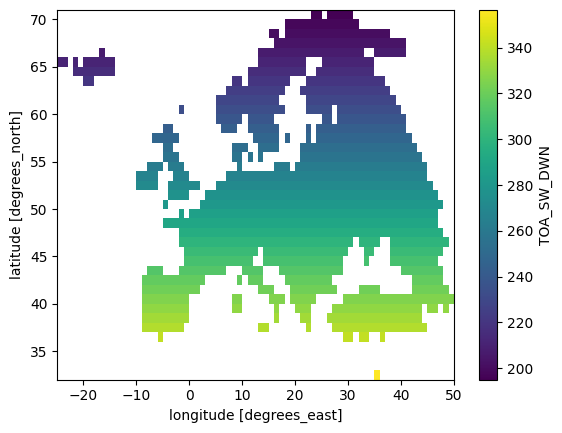

In [31]:
fname  ='/home/mgasanov/agro/spatial_sensitivity_analysis/data/solar_eu.nc'
solar = xr.open_dataset('../data/solar_eu.nc')
var = 'TOA_SW_DWN'
period = slice('2018-01-01', '2019-01-01')
solar.sel(time=period).mean(dim='time')[var].plot()

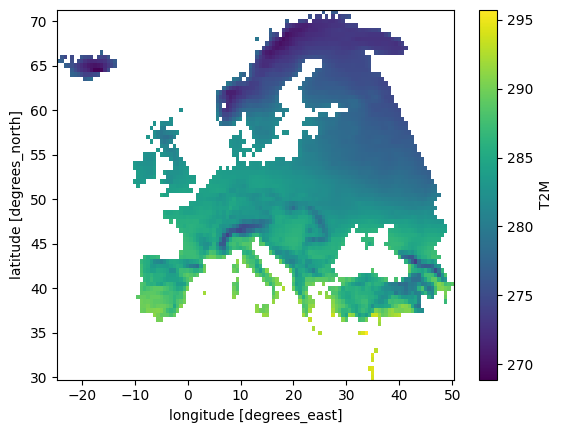

In [32]:
fname  ='/home/mgasanov/agro/spatial_sensitivity_analysis/data/weather_eu.nc'
weather = xr.open_dataset(fname)
var = 'T2M'
period = slice('2018-01-01', '2019-01-01')
weather.sel(time=period).mean(dim='time')[var].plot()

In [41]:
!pip3 -q install boto3


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [38]:
import boto3
# # settings = get_settings()
# os.environ["AWS_ACCESS_KEY_ID"] = "<?>"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "<?>"

def get_s3():
    """get_s3 session to S3

    get session with settings

    Returns:
        _type_: session
    """
    session = boto3.session.Session()
    s3_session = session.client(
        service_name="s3",
        endpoint_url="https://storage.yandexcloud.net",
        aws_access_key_id='',
        aws_secret_access_key='',
    )
    return s3_session


def uppload_file(fname: str, task_id: str, bucket_name: str = "skoltech") -> str:
    """uppload_file Uplaod file to S3

    Upload COG file to S3 storage

    Args:
        fname (str): path to COG file
        task_id (str): key for file in S3
        bucket_name (str, optional): bucket name in S3. Defaults to "skoltech".

    Returns:
        str: status - "Done"
    """
    s3_session = get_s3()
    s3_session.upload_file(fname, bucket_name, task_id)
    return "Done"



def download_file(fname: str, task_id: str, bucket_name: str = "skoltech") -> str:
    """download_file Download file from S3

    Download COG file from S3 storage

    Args:
        fname (str): path to COG file
        task_id (str): key for file in S3
        bucket_name (str, optional): bucket name in S3. Defaults to "skoltech".

    Returns:
        str: status - "Done"
    """
    s3_session = get_s3()
    s3_session.download_file(fname, bucket_name, task_id)
    return "Done"


def delete_file(task_id: str, bucket_name: str = "skoltech") -> str:
    """

    Parameters
    ----------
    task_id : str
    bucket_name : str

    Returns
    -------
    S3 API response
    """
    for_deletion = [{"Key": task_id}]
    s3_session = get_s3()
    response = s3_session.delete_objects(
        Bucket=bucket_name, Delete={"Objects": for_deletion}
    )
    print(response)
    return response


def get_file_url(key: str = "cog_msk_test") -> str:
    """get_file_url get URL to download by S3 key

    get URL to download by S3 key

    Args:
        key (str, optional): Key of object in S3. Defaults to "cog_msk_test".

    Returns:
        str: URL of object in S3
    """
    config = Config(signature_version=botocore.UNSIGNED)
    session = boto3.session.Session()
    s3_session = session.client(
        service_name="s3",
        config=config,
        endpoint_url="https://storage.yandexcloud.net",
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    )
    file_url = s3_session.generate_presigned_url(
        "get_object", ExpiresIn=0, Params={"Bucket": "skoltech", "Key": key}
    )
    print(file_url)
    return file_url

In [40]:
file = 'solar_eu.nc'
local_lulc = '../data/solar_eu.nc'
key = f"weather/{file}"
uppload_file(fname=local_lulc, task_id=key)

'Done'

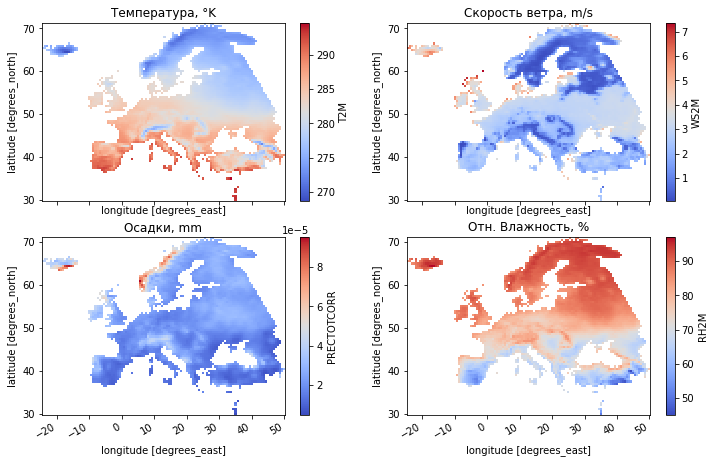

In [6]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.autofmt_xdate()

target_plots = ["T2M",
             "WS2M",
             "PRECTOTCORR",
             'RH2M']

target_names = ["Температура, °K",
             "Скорость ветра, m/s",
             "Осадки, mm",
             'Отн. Влажность, %']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    select = ds_eu.sel(time=slice('2022-01-01', '2022-12-31'))
    (select.mean(dim='time')[target_plots[i]]).plot(ax=ax, cmap='coolwarm')
    ax.set_title(target_names[i])
plt.savefig('./nasa_eu.png', dpi=300)

## 2. Агротехнологии

In [7]:
# !gdown 1TT1zf1jjQ6Jf8c2phy1mPKqhXcZ8mVsG
# !gzip -d Soybeans.crop.calendar.fill.nc.gz

In [23]:
class Agrotechnology:
    """
    TO-DO:
    1. Add: major agrotech info for DSSAT, MONICA and WOFOST
    2. AWS: add reading files from AWS S3 storage or from source Drive files (archive?)
    """

    def __init__(self,crop:str, pathCalendar: str='./') -> None:

        self.pathCalendar = pathCalendar
        self.dictCalendars = {
            "barley": "Barley.crop.calendar.fill.nc",
            "soybean": "Soybeans.crop.calendar.nc",
            "sunflower": "Sunflower.crop.calendar.fill.nc",
            "maize": "Maize.crop.calendar.fill.nc",
            "wheat": "Wheat.Winter.crop.calendar.nc",
        }
        self.dataset=xr.open_dataset(os.path.join(pathCalendar,self.dictCalendars[crop] ))

    def getCropCalendar(
        self, lon: float, lat: float, year: str = "2022"
    ) -> dict:

        harvest_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").harvest.values
        )
        plant_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").plant.values
        )
        if (math.isnan(harvest_flt)) or (math.isnan(plant_flt)):
            return {"plant_day": "NaN", "harvest_day": "NaN"}
        harvest_day = str(
            dt.datetime.strptime(f"{year} {int(harvest_flt)}", "%Y %j").date()
        )
        plant_day = str(
            dt.datetime.strptime(f"{year} {int(plant_flt)}", "%Y %j").date()
        )

        if harvest_day < plant_day:
            plant_day = plant_day.replace(year, year-1)
        return {"plant_day": dt.datetime.strptime(plant_day, '%Y-%m-%d'),
                "harvest_day": dt.datetime.strptime(harvest_day, '%Y-%m-%d')}


In [24]:
agrocalendar = Agrotechnology(crop='wheat', pathCalendar='./')

In [26]:
agrocalendar.getCropCalendar(lon=54, lat=57, year = 2023)

{'plant_day': 'NaN', 'harvest_day': 'NaN'}

In [1]:
# ds_plant = clip_by_region(ds=ds_plant)

In [30]:
import contextily as cx

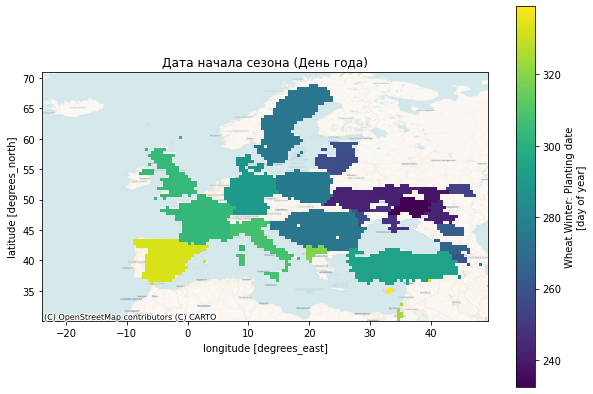

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
ds_plant = agrocalendar.dataset
gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
gdf = gdf.set_crs('EPSG:4326')
ds_plant.rio.write_crs("epsg:4326", inplace=True)
clipped = ds_plant['plant'].rio.clip(gdf.geometry.values, gdf.crs)
clipped.plot(ax=ax)
ax.set_title("Дата начала сезона (День года)")
cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.CartoDB.Voyager)
plt.savefig('./start_season.png', dpi=300)

In [12]:
ds_plant = agrocalendar.dataset
ds_plant = clip_by_region(ds=ds_plant)
ds_plant['plant'].plot()

: Could not convert object to NumPy timedelta

## 3. Почва

In [42]:
from pandas import isna

class SoilSA:
    def __init__(self):
        self.df_eu = pd.read_csv('./soil_coords_eu.csv')
        self.eu_list = self.df_eu.values.tolist()
        self.folder = '/mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/'
        self.nodes = np.hstack((self.df_eu[['X']].values,self.df_eu[['Y']].values))
    def van_genuchten(self, theta_r, theta_s, alpha, n, h):
        '''
        Van Genuchten function for soil water retention. Returns theta for a given h (kPa)
        
        Arguments
        ----------
        theta_r: float
            residual water content
        theta_s: float
            saturated water content
        log10(alpha): float
            van Genuchten 'alpha' parameter (1/cm)
        log10(n): float
            van Genuchten 'n' parameter
        '''
        alpha = 10**alpha 
        n = 10**n
        m = 1 - 1/n 
        theta = theta_r + (theta_s - theta_r)/(1 + abs(alpha * h)**n)**m
        return theta

    def aggregate_top_layer(self, soil):
        # top_layer = pd.DataFrame()
        # to_drop = []
        for depth in list(soil.layers.keys()):
            if depth < 30:
                # top_layer = pd.concat([top_layer, soil.layers[depth]], axis=1)
                soil.layers.pop(depth)
        # top_layer=top_layer.mean(axis=1)
        # top_layer.iloc[0] = 30
        # soil.layers[30] = top_layer
        # soil.layers[30] = soil.layers[30].fillna(soil.layers[90]['SLMH'])
        # soil.layers = dict(sorted(soil.layers.items()))
        soil.n_layers = len(soil.layers)
        return soil 

    def estimate_missing(self, soil_layer):
            # Soil Hydraulic parameters are estimated from van_genuchten equation's parameters.
            # Those parameters are estimated using Pedo-Transfer Funcitons (PTF). For this case
            # USDA rosetta model (Zhang et al., 2017) was used. doi: 10.1016/j.jhydrol.2017.01.004
            if isna(soil_layer.SBDM):
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL]]
                )
                vangenuchten_pars, _, _ = rosetta(2, soil_data)
                # Calculate SBDM
            else:
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL, soil_layer.SBDM]]
                )
                vangenuchten_pars, _, _ = rosetta(3, soil_data)
    
            vangenuchten_pars = vangenuchten_pars[0]
            soil_layer.SSAT = vangenuchten_pars[1]
            soil_layer.SSKS = (10**vangenuchten_pars[-1]) / 24
            soil_layer.SLLL = self.van_genuchten(*vangenuchten_pars[:-1], h=1500)
            soil_layer.SDUL = self.van_genuchten(*vangenuchten_pars[:-1], h=33)     
        
            if isna(soil_layer.SLOC):
                soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                soil_layer.SBDM = 1.386 - 0.078*soil_layer.SLOC + 0.001*soil_layer.SLSI + 0.001*soil_layer.SLCL
            else:
                soil_layer.SBDM = 1.72 - 0.294*soil_layer.SLOC**0.5
            
            if isna(soil_layer.SLOC): soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                
            return soil_layer

    def closest_node(self, node, nodes):
        nodes = np.asarray(nodes)
        deltas = nodes - node
        dist_2 = np.einsum('ij,ij->i', deltas, deltas)
        return np.argmin(dist_2)
    def get_soil_by_coords(self, lon, lat):
        node = [lon, lat] ##weather pointt
        # nodes = np.hstack((self.df_eu[['X']].values,self.df_eu[['Y']].values))
        node_idx = self.closest_node(node, self.nodes)
        soil_profile_number,soil_profile_country = self.eu_list[node_idx][2:4]
        # soil_profile_number = self.eu_list[node_idx][2]
        # soil_profile_country = self.eu_list[node_idx][3]
        dr = os.path.join(self.folder, str(soil_profile_country)+'.SOL')
        soilprofile = SoilProfile(
            file=dr,
            profile = soil_profile_number)
        return soilprofile

soil_sa = SoilSA()

## 4. Запуск расчета урожайности

In [12]:
year = 2022
ds_eu_year=ds_eu.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
ds_eu_solar_year=ds_eu_solar.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))

In [13]:
# Load weather data from AWS to local RAM
ds_eu_year.load()
ds_eu_solar_year.load()

<xarray.Dataset>
Dimensions:            (lat: 39, lon: 75, time: 365)
Coordinates:
  * lat                (lat) float64 32.5 33.5 34.5 35.5 ... 67.5 68.5 69.5 70.5
  * lon                (lon) float64 -24.5 -23.5 -22.5 -21.5 ... 47.5 48.5 49.5
  * time               (time) datetime64[ns] 2022-01-01 ... 2022-12-31
    spatial_ref        int64 0
Data variables:
    TOA_SW_DWN         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

In [14]:
dssat_runner = DSSATModel(ds_weather = ds_eu_year, 
                          ds_solar = ds_eu_solar_year)

In [17]:
container = []
for lat in tqdm_notebook(ds_eu.lat.values):
    for lon in ds_eu.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "Yield": np.nan,
                        "Problem": "no weather available",
                    }
                )
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "Yield": np.nan,
                        "Problem": "no agro calendar available",
                    }
                )
            continue
        try: 
            start = time.time()
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
    

        try:
            crop_yield = dssat_runner.compute(
                crop_name="Soybean",
                cultivar="999991",
                lat=lat,
                lon=lon,
                harvest=calendar["harvest_day"],
                sowing=calendar["plant_day"],
                soil=soil)
            container.append(
                {"lon": lon, "lat": lat, "Yield": crop_yield, "Problem": "OK"}
            )
        except Exception as e:
            container.append(
                {"lon": lon, "lat": lat, "Yield": np.nan, "Problem": e}
            )
            continue

/tmp/ipykernel_4055/2735713558.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lat in tqdm_notebook(ds_eu.lat.values):


  0%|          | 0/83 [00:00<?, ?it/s]

/tmp/dssatkqkqzcot created.
Static files copied to /tmp/dssatkqkqzcot.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24  80  1389   549     0   193   232    43     0   -99      0  242
/tmp/dssatkqkqzcot and its content has been removed.
/tmp/dssatwevbseea created.
Static files copied to /tmp/dssatwevbseea.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24  81  1387   529     0   193   237    38     0   -99      0  242
/tmp/dssatwevbseea and its content has been removed.
/tmp/dssatchnutska created.
Static files copied to /tmp/dssatchnutska.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  24  81  1413   544     0   192   236 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [29]:
df_soil = pd.DataFrame(container)

In [31]:
mask = df_soil['Yield'].isna()
df_to_compute =df_soil.loc[~mask]

In [33]:
df_soil.to_csv('../data/soybean_yield.csv')

In [24]:
df_to_compute.shape

(3433, 4)

In [27]:
df_points = pd.read_csv('./df_yield.csv')
mask = df_points['Yield'].isna()
df_to_compute = df_points.loc[~mask]

df_to_compute.shape

(3641, 4)

In [162]:
df_points = pd.read_csv('./df_yield.csv')
mask = df_points['Yield'].isna()
df_to_compute = df_points.loc[~mask]
for i, df in enumerate(np.array_split(df_to_compute, 10)):
    df.to_csv(f'sa_task_{i}.csv', index=0)

## Сбор почвенных параметров для карты 

In [67]:
container = []
for lat in tqdm_notebook(ds_eu.lat.values):
    for lon in ds_eu.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":np.nan, 
                        "SLCL": np.nan, 
                        "SLSI": np.nan,
                        "Problem": "no weather available",
                    }
                )
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":np.nan, 
                        "SLCL": np.nan, 
                        "SLSI": np.nan,
                        "Problem": "no agro calendar available",
                    }
                )
            continue
        try: 
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            print(e)
            soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
        soil_dict = soil.layers[30].to_dict()
        container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":soil_dict['SLOC'], 
                        "SLCL":soil_dict['SLCL'], 
                        "SLSI":soil_dict['SLSI'], 
                        "Problem": "NO",
                    }
                )

/tmp/ipykernel_4055/3605088801.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lat in tqdm_notebook(ds_eu.lat.values):


  0%|          | 0/83 [00:00<?, ?it/s]

SI02283285 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
SI02283292 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
SI02283300 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
MD02153850 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/MD.SOL
CZ02024092 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/CZ.SOL


In [68]:
df_soil = pd.DataFrame(container)

In [49]:
ds_eu['T2M'].shape

(16071, 83, 120)

In [57]:
np.nanmin(x)

1.86

In [60]:
df_soil['SLCL'].max()

13.25

In [69]:
x = df_soil['SLOC'].values

In [81]:
for soil_p in ["SLOC","SLCL",'SLSI']:
    x = df_soil[soil_p].values
    ds_eu[soil_p]=(['lat', 'lon'],  x.reshape(83,120))

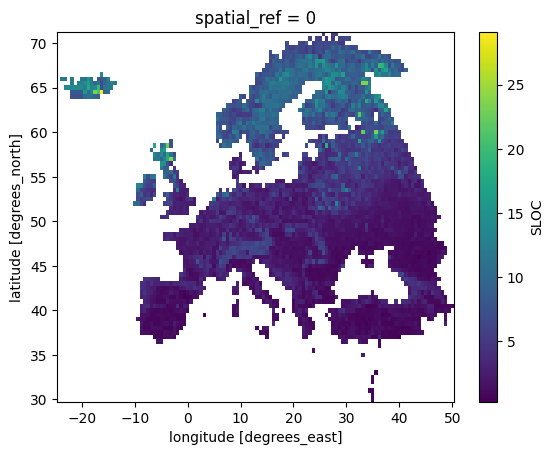

In [77]:
ds_eu['SLOC'].plot()

In [78]:
!pip3 -q install contextily



In [79]:
import contextily as cx

In [83]:
naming = {"SLOC":"Органическое вещество почвы",
        "SLCL": "Содержание глинистой фракции, %",
        'SLSI': "Содержание илистой фракции, %"}

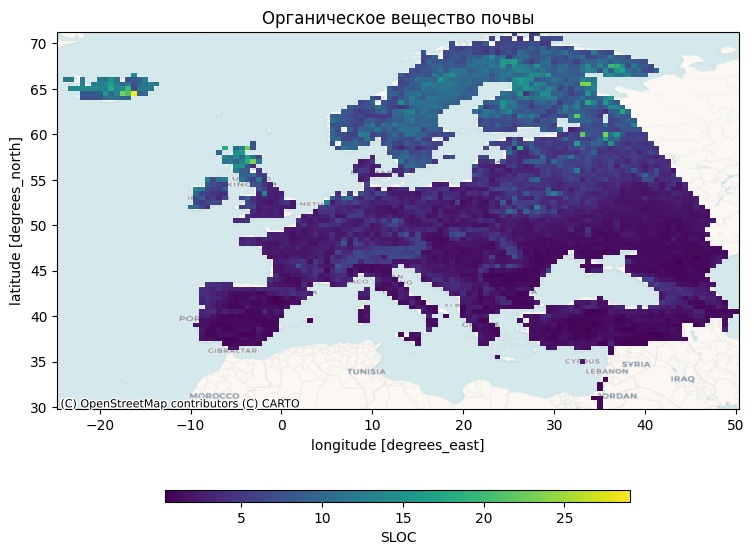

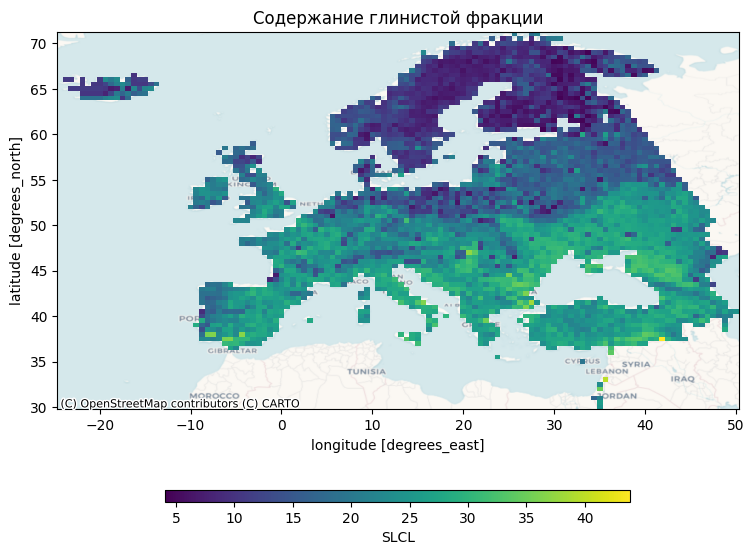

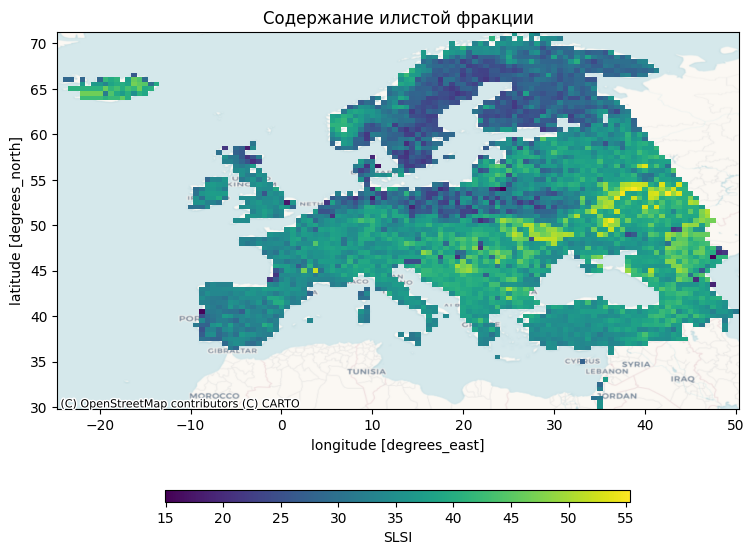

In [88]:
for soil_p in ["SLOC","SLCL",'SLSI']:
    fig, ax = plt.subplots(figsize=(10, 7))
    ds_eu[soil_p].plot(ax=ax, cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40})
    ax.set_title(naming[soil_p])
    cx.add_basemap(ax, crs="epsg:4326",
                   source=cx.providers.CartoDB.Voyager)
    plt.savefig(f'./{soil_p}_map.png', dpi=300)
    # break

In [43]:
soil.layers[30].to_dict()['SLOC']


1.86

## 5. Анализ чувствительности

| Name       | Parameter    | Range     | Unit | 
|------------|--------------|------------------------------------|-------------|
| SRGF       |     Root growth factor, soil only      |        0.0 to 1.0 | -  | 
| SBDM       |  Bulk density    | - | g/cm3  | 
| SLOC       |  Organic carbon  | - | g/cm3  | 
| SLCL       |  Clay    | - | g/cm3  | 
| SLSI       |  Silt    | - | g/cm3  | 
| SLHW       |  Soil pH in water    | - | g/cm3  | 


In [95]:
def get_bounds(soil, soil_cols):
    top_layer = soil.layers[30]
    lower = top_layer[soil_cols].astype(float) * 0.7
    upper = top_layer[soil_cols].astype(float) * 1.3
    upper['SRGF']=1.0
    while upper.SLSI + upper.SLSI > 100:
        upper.SLSI -= 1
        upper.SLSI -= 1
        print(upper.SLSI)
    assert upper.SLSI + upper.SLSI < 100, "Sum of Silt and Clay should be less then 100"
    
    lower = lower.round(4)
    upper = upper.round(4)
    bounds = [[low, up] for low, up in zip(lower, upper)]
    return bounds

def evaluate_soil(X: np.ndarray, soil, soil_cols: list, lon:float, lat:float):
    for i, key in enumerate(soil_cols):
        soil.layers[30][key] = X[i]
    soil.layers[30] = soil_sa.estimate_missing(soil.layers[30])
    crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                     cultivar = '999991',
                    lat=lat,
                    lon=lon,
                    harvest = calendar['harvest_day'],
                    sowing = calendar['plant_day'],
                    soil = soil)
    return crop_yield


def rename(df):
    df = df.reset_index()
    df = df.rename(columns={'index':'soil_parameter'})
    return df

In [93]:

def conduct_sensitivity(lon=lon, lat=lat, soil=soil):
    soil_cols = ["SLOC","SLCL","SLSI"]
    
    # soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
    # soil = soil_sa.aggregate_top_layer(soil)
    
    bounds = get_bounds(soil=soil, soil_cols=soil_cols)
    
    sp = ProblemSpec({
            "names": soil_cols,
            "groups": None,
            "bounds": bounds,
            "outputs": ["Y"],
        })
    
    sp.sample_sobol(32)
    
    
    Y = np.zeros([sp.samples.shape[0]])
    print(Y.shape)
    for i, X in tqdm_notebook(enumerate(sp.samples)):
        Y[i] = evaluate_soil(X, soil=soil,soil_cols=soil_cols, lon=lon, lat=lat)
    
    
    sp.set_results(Y)
    sp.analyze_sobol()
    total_Si, first_Si, second_Si = sp.to_df()
    return total_Si, first_Si, second_Si

In [96]:
lon=41.1
lat=49.9
point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
if point_weather['T2M'].sum().values==0:
    container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
if calendar['plant_day'] == 'NaN':
    container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
try: 
    start = time.time()
    soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
except KeyboardInterrupt as e:
    print('Interrupted')
    try:
        sys.exit(130)
    except SystemExit:
        os._exit(130)
except Exception as e:
    soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)


crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                     cultivar = '999991',
                    lat=lat,
                    lon=lon,
                    harvest = calendar['harvest_day'],
                    sowing= calendar['plant_day'],
                    soil = soil)
total_Si, first_Si, second_Si = conduct_sensitivity(lon=lon, lat=lat, soil=soil)

/tmp/dssatrvhmbgoe created.
Static files copied to /tmp/dssatrvhmbgoe.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  5772  1981   288   209   489    90     0   -99      0  242
/tmp/dssatrvhmbgoe and its content has been removed.
(256,)


/tmp/ipykernel_4055/229607129.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, X in tqdm_notebook(enumerate(sp.samples)):


0it [00:00, ?it/s]

/tmp/dssathfvrqxlg created.
Static files copied to /tmp/dssathfvrqxlg.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   242   507   114     0   -99      0  249
/tmp/dssathfvrqxlg and its content has been removed.
/tmp/dssatrhewosjg created.
Static files copied to /tmp/dssatrhewosjg.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   249   509   122     0   -99      0  232
/tmp/dssatrhewosjg and its content has been removed.
/tmp/dssathllorkyz created.
Static files copied to /tmp/dssathllorkyz.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   243   504 

In [179]:
df_general = pd.DataFrame()
for lat in tqdm_notebook(to_compute_df.lat.values):
    for lon in to_compute_df.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
            continue
        try: 
            start = time.time()
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
    

        crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                             cultivar = '999991',
                            lat=lat,
                            lon=lon,
                            harvest = calendar['harvest_day'],
                            sowing= calendar['plant_day'],
                            soil = soil)
        total_Si, first_Si, second_Si = conduct_sensitivity(lon=lon, lat=lat, soil=soil)
        first_Si = first_Si.reset_index().rename(columns={'index':'soil'})
        total_Si = total_Si.reset_index(drop=True)
        second_Si = second_Si.reset_index().rename(columns={'index':'soil_interaction'})
        df_rep = pd.concat([first_Si, total_Si, second_Si], axis=1)
        df_rep['lon']=lon
        df_rep['lat']=lat
        df_general = pd.concat([df_general, df_rep])
        df_general.to_csv(os.path.splitext(fname)[0]+'_result_Sobol.csv')
        container.append({"lon":lon, "lat":lat, "Yield":crop_yield, 'Problem': "NO"})
        df_y = pd.DataFrame(container)
        df_y.to_csv(os.path.splitext(fname)[0]+'_result_yield.csv')

/tmp/ipykernel_16877/881549657.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lat in tqdm_notebook(to_compute_df.lat.values):


  0%|          | 0/365 [00:00<?, ?it/s]

/tmp/dssatmrpvfykc created.
Static files copied to /tmp/dssatmrpvfykc.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4296  1562   253   164   466    84     0   -99      0  384
/tmp/dssatmrpvfykc and its content has been removed.
51.261
49.261
(160,)


/tmp/ipykernel_16877/2052774989.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, X in tqdm_notebook(enumerate(sp.samples)):


0it [00:00, ?it/s]

/tmp/dssatgtshpexh created.
Static files copied to /tmp/dssatgtshpexh.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4297  1562   253   155   475    70     0   -99      0  387
/tmp/dssatgtshpexh and its content has been removed.
/tmp/dssatsjwrnpjn created.
Static files copied to /tmp/dssatsjwrnpjn.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4297  1562   253   166   485    74     0   -99      0  387
/tmp/dssatsjwrnpjn and its content has been removed.
/tmp/dssatstbrcsgo created.
Static files copied to /tmp/dssatstbrcsgo.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4290  1562   253   168   481 


KeyboardInterrupt



In [43]:
soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)

In [44]:
soil

*RU02080573  RUS   SandyLoam   200    ISRIC soilgrids + HC27
@SITE        COUNTRY          LAT     LONG SCS FAMILY
 -99              RU        49.875   41.125     HC_GEN0012                      
@ SCOM  SALB  SLU1  SLDR  SLRO  SLNF  SLPF  SMHB  SMPX  SMKE
    BK  0.10   6.0  0.50  75.0  1.00  1.00 SA001 SA001 SA001
@  SLB  SLMH  SLLL  SDUL  SSAT  SRGF  SSKS  SBDM  SLOC  SLCL  SLSI  SLCF  SLNI  SLHW  SLHB  SCEC  SADC
     5 A     0.061 0.150 0.390 1.000  4.29  1.33  2.89  10.4  25.9   -99 0.120   6.3   -99  14.3   -99
    15 A     0.068 0.158 0.390 0.850  3.82  1.35  2.44  11.7  25.2   -99 0.090   6.3   -99  12.5   -99
    30 AB    0.078 0.168 0.390 0.700  3.32  1.38  1.86  13.3  24.4   -99 0.070   6.5   -99  12.1   -99
    60 BA    0.089 0.180 0.390 0.500  2.77  1.43  1.19  15.2  23.4   -99 0.060   6.6   -99  12.7   -99
   100 B     0.089 0.178 0.390 0.000  2.82  1.49  0.69  15.2  22.8   -99 0.000   6.7   -99  12.8   -99
   200 BC    0.080 0.166 0.390 0.000  3.34  1.55  0.39  13.7  22